# VAE Variational Autoencoder

import needest modules

In [24]:
import torch
import torch.nn as nn
from torch import optim 
from torchinfo import summary
from torchmetrics import Accuracy
from torch.utils.data import Dataset, DataLoader
from model import VAE
import matplotlib.pyplot as p
from torch.autograd import Variable 
import matplotlib.pyplot as plt
from data import Ego4d, DEVICE, BATCH_SIZE, transform1, transform2, ResumableRandomSampler

prepare dataset for training

In [25]:
print('transform initializate sucsess')
train_dataset = Ego4d(img_dir='/home/qwest/data_for_ml/4_25',
                           transform1=transform1,
                           transform2=transform2)
print("train_dataset init")
sampler = ResumableRandomSampler(train_dataset)
print("train_sampler init")
train_loader = DataLoader(dataset=train_dataset,
                           batch_size=32,
                           shuffle=False,
                           sampler=sampler,
                           num_workers=6)
print("train_loader init")

transform initializate sucsess
train_dataset init
train_sampler init
train_loader init


In [26]:
print("Len of trainloader: ",len(train_loader))

Len of trainloader:  5532


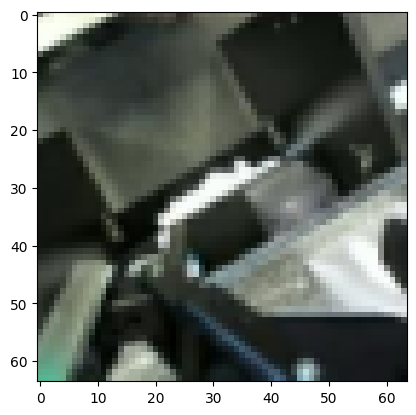

In [23]:
x = next(iter(train_loader))
plt.imshow(x[0].cpu().numpy().transpose(1, 2, 0))

In [27]:
torch.save(sampler.get_state(), "test_samp.pth")

setup param's for VAE training

In [28]:
lr = 0.001
epochs = 70
latent_dim = 128

create model & optimizer with parametrs ^^^ 

In [29]:
model = VAE(latent_dim, batch_size=32).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [6]:
model.load_state_dict(torch.load('model.pt', weights_only=True))

<All keys matched successfully>

## OR

In [31]:
checkpoint = torch.load('/home/qwest/project/PycharmProjects/Reinforsment_Learning/VAE/weights/main/VAE_checkpoint_128_80.pt')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

/tmp/ipykernel_173450/4226906568.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/home/qwest/project/PycharmProjects/Reinforsment_Learning/VAE/w

ModuleNotFoundError: No module named 'VAE'

create train func 

In [14]:
def train(epoch):
        """
        train VAE model.

        Args:
        epoch (int): number of epoch.
        """
        model.train()
        print(f'Epoch {epoch} start')
        eval_loss = 0
        # Loop through all batches in the training dataset
        for _, data in enumerate(train_loader):
                data = data.to(DEVICE)
                optimizer.zero_grad()
                
                recon_batch, mu, logvar = model(data)
                loss = model.loss_function(recon_batch, data, mu, logvar)
                eval_loss += loss
                
                loss.backward() # Compute the gradients with respect to the model parameters
                
                optimizer.step() # Update the model parameters using the optimizer

        torch.save({
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss':loss,
                        'epoch':epoch,
                        'full_model':model,
                        'sampler_state':sampler.get_state(),
                        },
                        f'VAE/weights/main/VAE_checkpoint_{latent_dim}_{epoch}.pt')
        
        print(f"Avg loss: {loss:2f} \n")
        #recon_img, _, _ = model(x[:1].to(DEVICE))
        #img = recon_img.view(3, 64, 64).detach().cpu().numpy().transpose(1, 2, 0)
        #f = p.imshow(img)
        #p.show()


train model with logging on mlflow 

In [15]:
# Log model summary.|
with open("model_summary.txt", "w") as f:
    f.write(str(summary(model)))

for t in range(24, epochs+1):
    train(t)

## Test model

In [7]:
# checkpoint = torch.load('/home/qwest/project/PycharmProjects/Reinforsment_Learning/test_W/VAE_checkpoint_1283.pt')
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']
model.eval()

VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2), bias=False)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2), bias=False)
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2), bias=False)
    (8): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Conv2d(512, 256, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 512, kernel_size=(4, 4)

test on exist image 

torch.Size([32, 3, 64, 64])


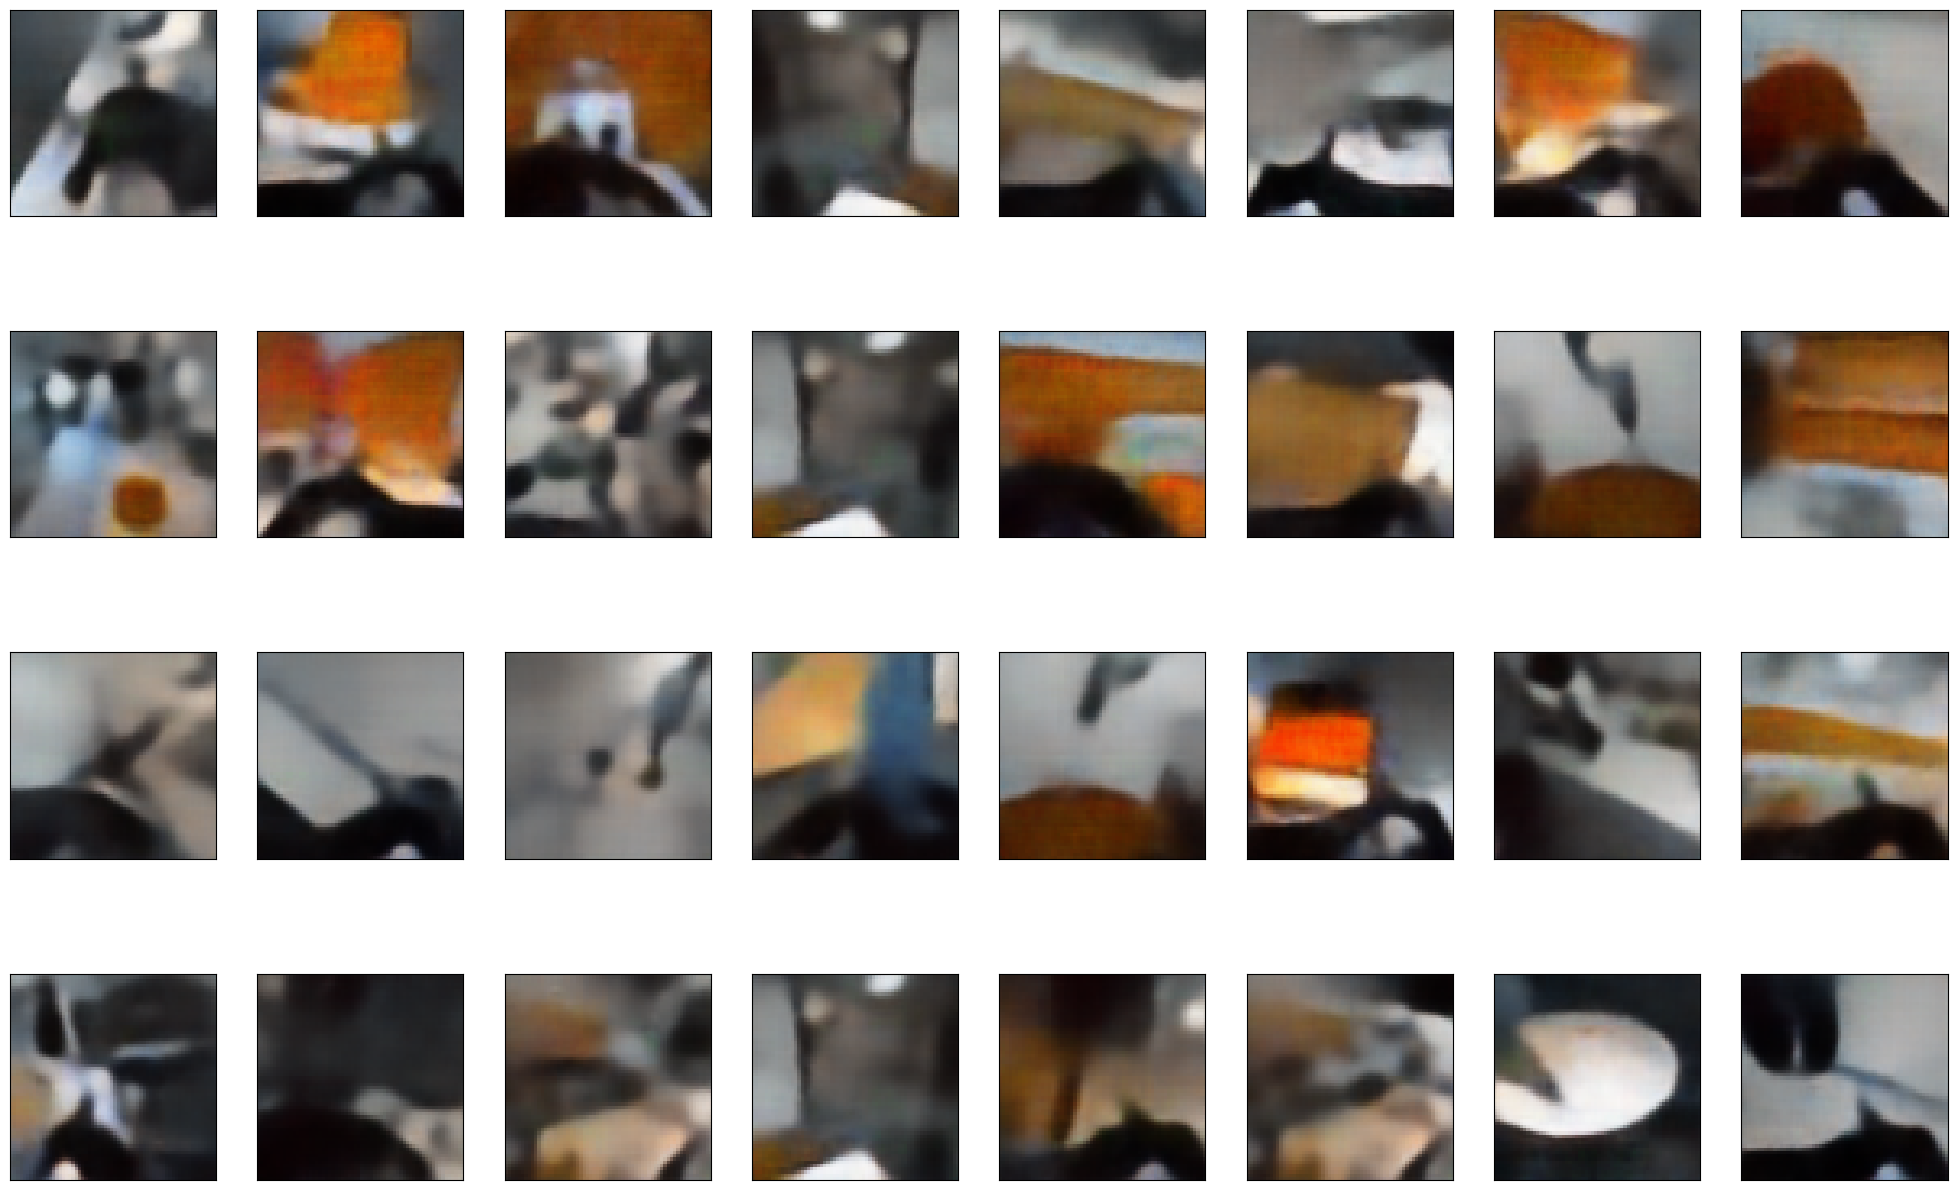

In [9]:
x = next(iter(train_loader))
print(x.size())
reconstructed, mu, _ = model(x.to(DEVICE))
reconstructed = reconstructed.view(-1, 3, 64, 64).detach().cpu().numpy().transpose(0, 2, 3, 1)

fig = plt.figure(figsize=(25, 16))
for ii, img in enumerate(reconstructed):
    ax = fig.add_subplot(4, 8, ii + 1, xticks=[], yticks=[])
    plt.imshow((img))

transition of image to image

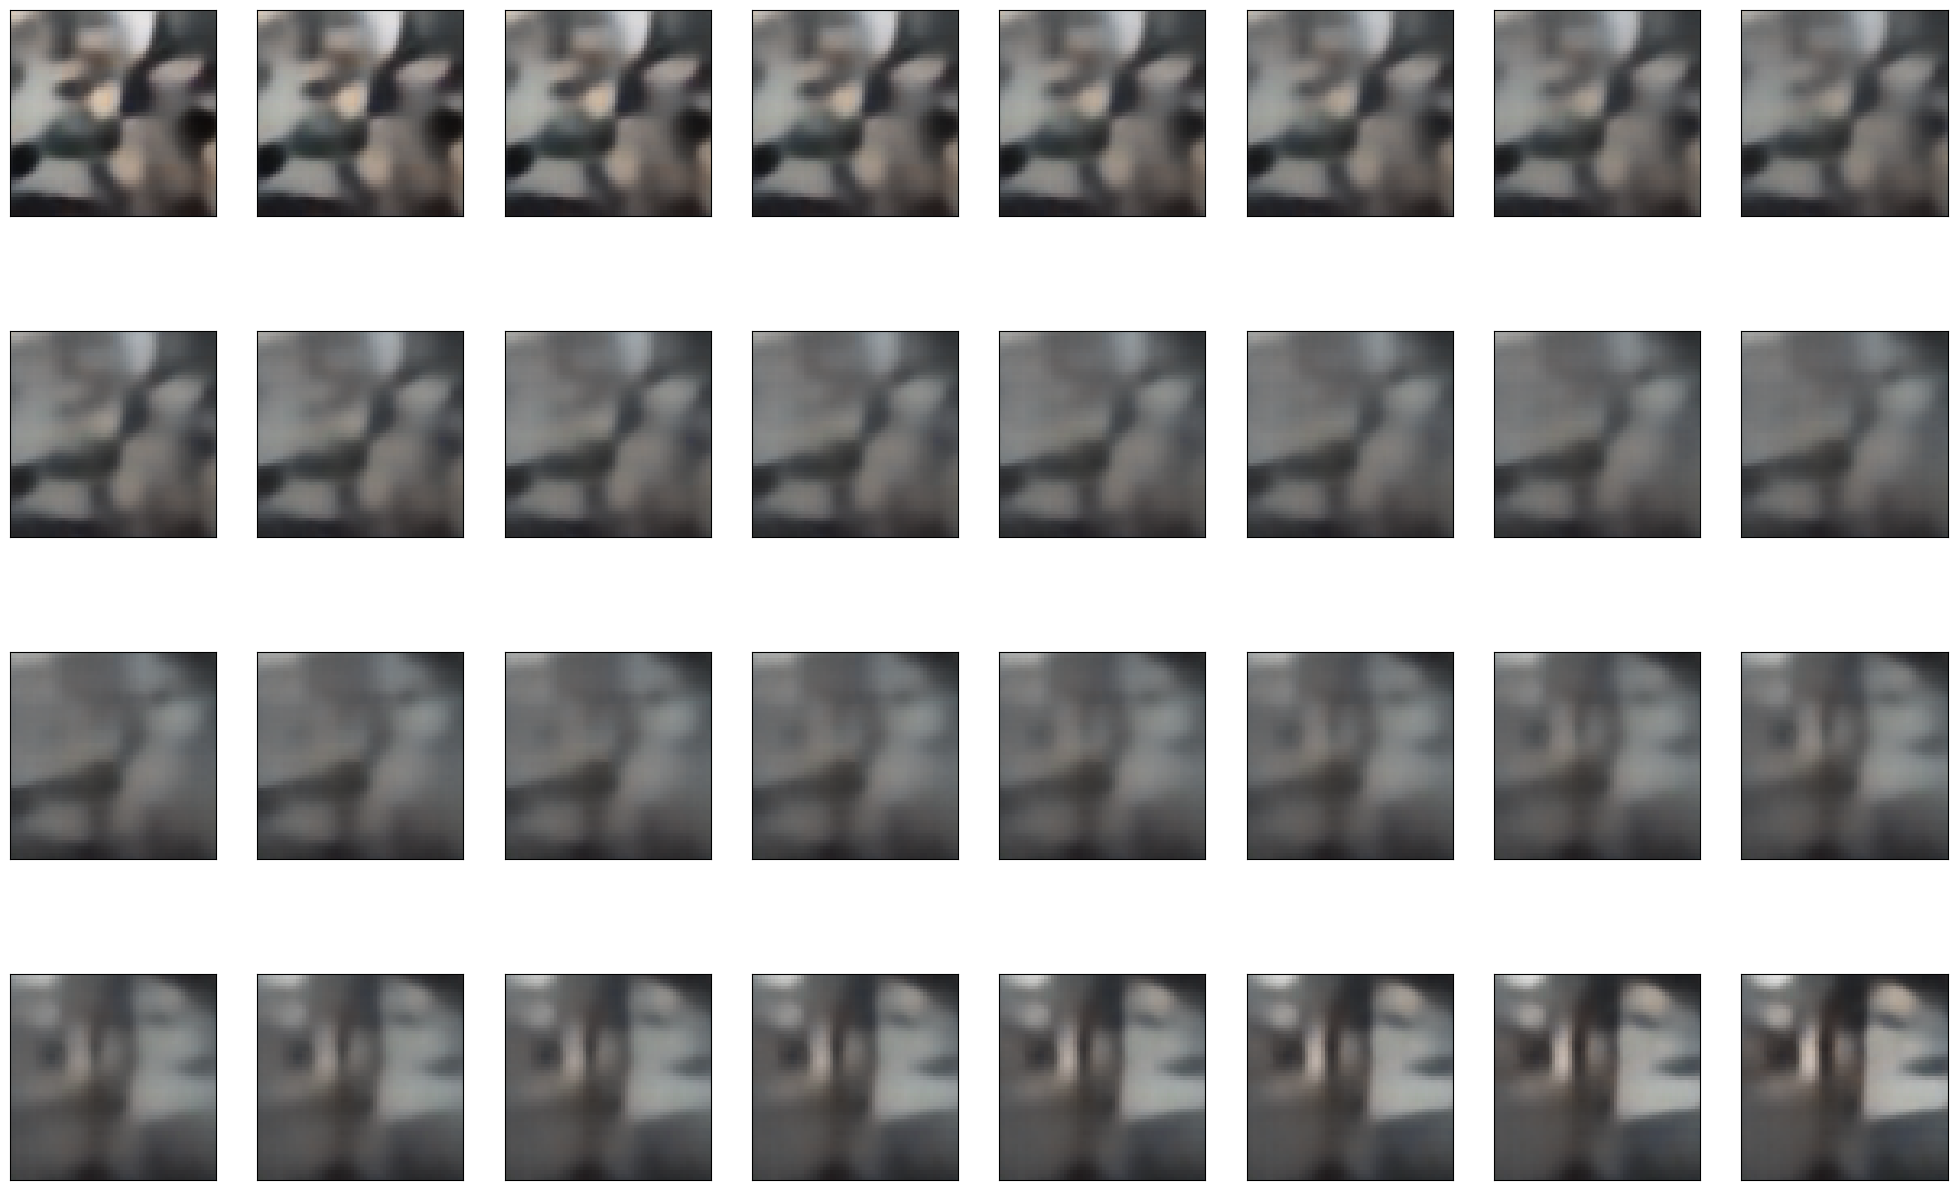

In [9]:
first_dog_idx = 3
second_dog_idx = 8

dz = (mu[second_dog_idx] - mu[first_dog_idx]) / 31
walk = Variable(torch.randn(32, latent_dim, 4, 4)).to(DEVICE)
walk[0] = mu[first_dog_idx]

for i in range(1, 32):
    walk[i] = walk[i-1] + dz
walk = model.decoder(walk).detach().cpu().numpy().transpose(0, 2, 3, 1)

fig = plt.figure(figsize=(25, 16))
for ii, img in enumerate(walk):
    ax = fig.add_subplot(4, 8, ii + 1, xticks=[], yticks=[])
    plt.imshow((img))

generate image from nose

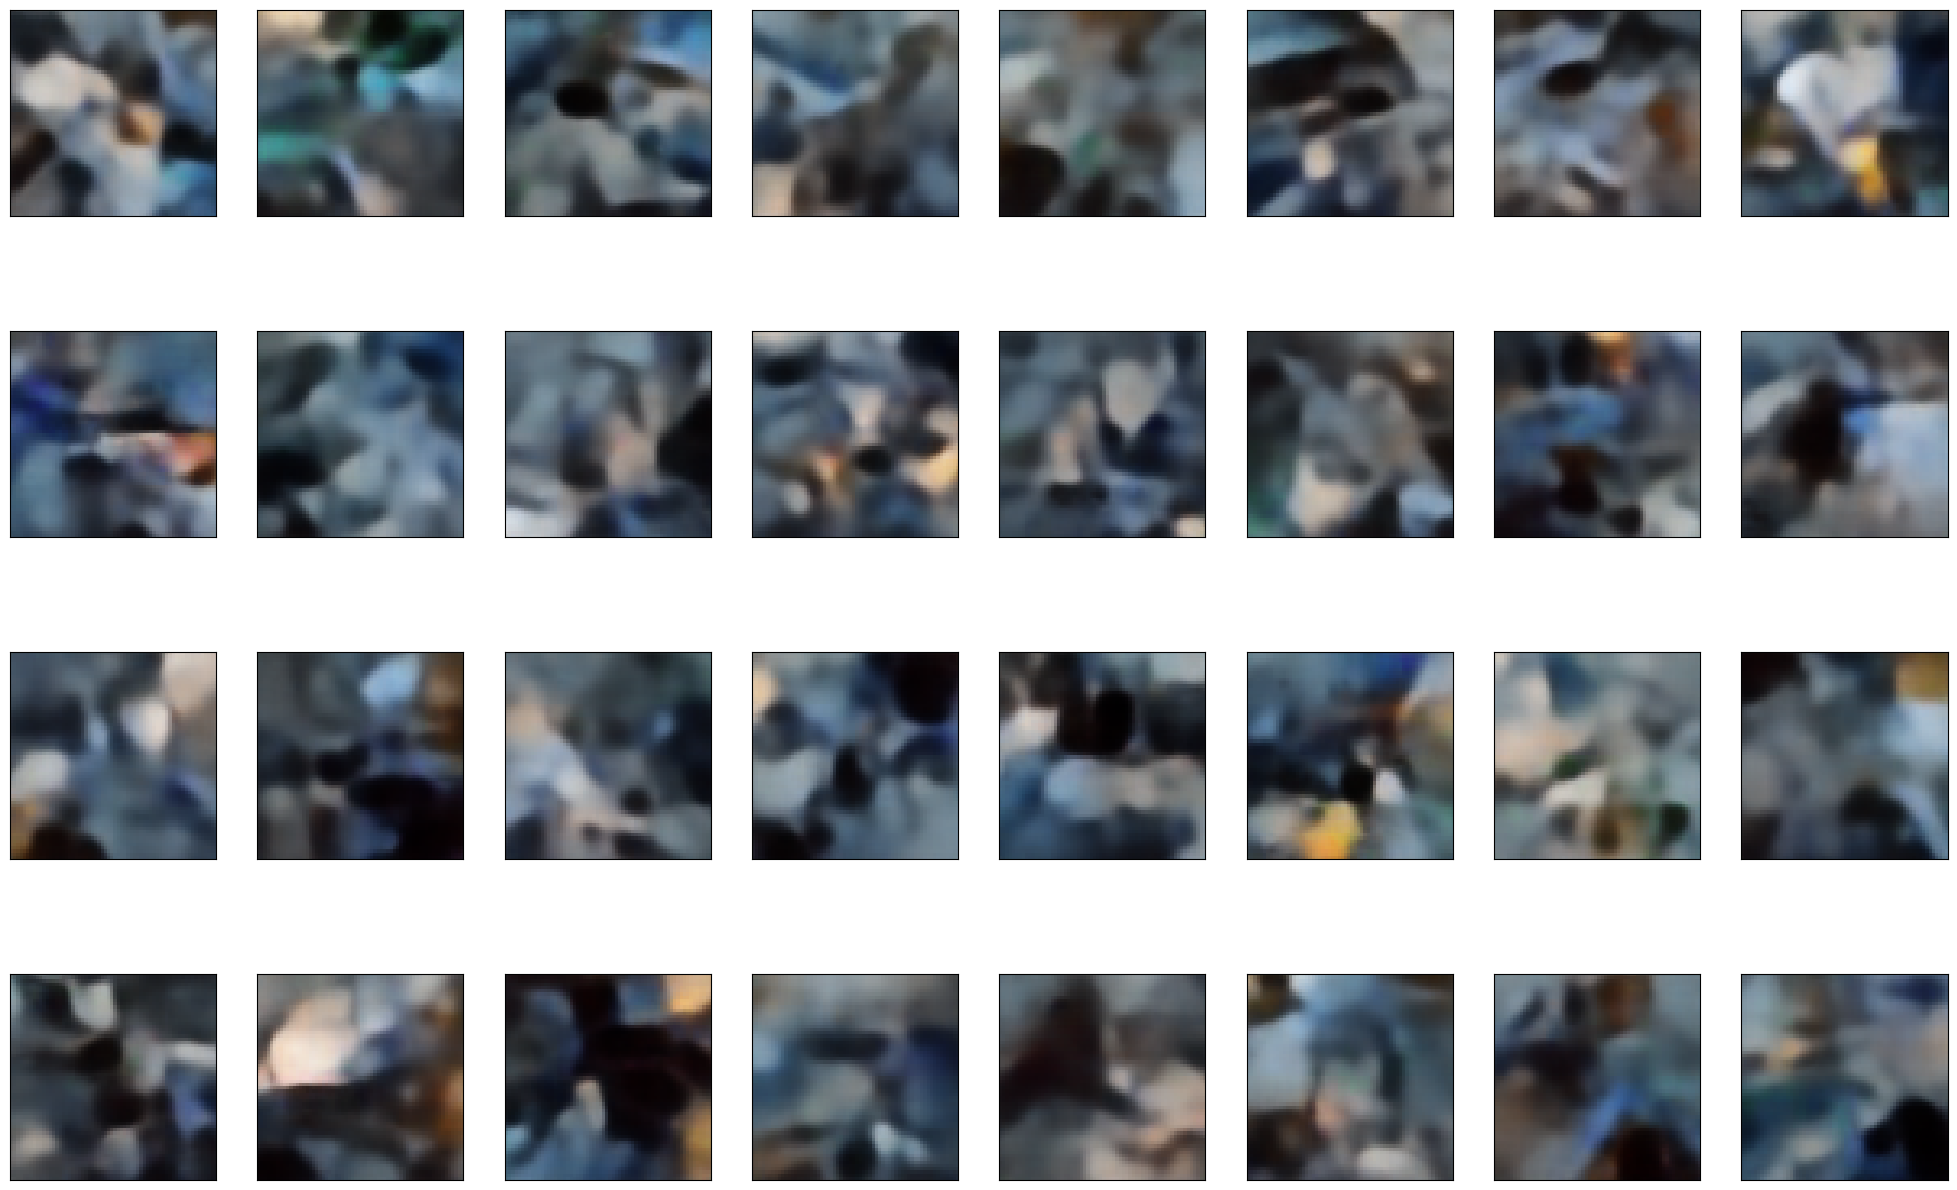

In [10]:
samples = Variable(torch.randn(32, latent_dim, 4, 4)).to(DEVICE)
samples = model.decoder(samples).detach().cpu().numpy().transpose(0, 2, 3, 1)

fig = plt.figure(figsize=(25, 16))
for ii, img in enumerate(samples):
    ax = fig.add_subplot(4, 8, ii + 1, xticks=[], yticks=[])
    plt.imshow((img))

In [11]:
torch.save(model.state_dict(), "model.pt")

In [17]:
reconstructed, _, _ = model(x[0][None, :, :, :].to(DEVICE))

In [18]:
reconstructed = reconstructed.view(-1, 3, 64, 64).detach().cpu().numpy().transpose(0, 2, 3, 1)


In [23]:
reconstructed[0].shape

(64, 64, 3)